### Navier Stokes in JAX

$\begin{aligned}
	&w_t+\boldsymbol{u}\cdot\nabla w=\frac{1}{\mathrm{Re}}\Delta w,\quad in[0,T]\times \Omega, \\
	&\nabla \cdot \boldsymbol{u}=0,\quad in[0,T]\times \Omega, \\
	&w(0,x,y)=w_0(x,y),\quad in\Omega, \\
	&\Omega=[0,2\pi]^2, Re=100
\end{aligned}$

In [1]:
import jax 
import jax.numpy as jnp
import numpy as np
import flax
from flax import linen as nn
from flax.training import train_state
import optax
import scipy
import matplotlib.pyplot as plt
import pickle
import copy
import time
from tqdm import trange
from typing import Sequence
from functools import partial

import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

In [2]:
M_x = 5
M_y = 5
L_x = 2*jnp.pi
L_y = 2*jnp.pi
d0 = 2*M_x + 2*M_y + 4*M_x*M_y + 1
layer_sizes_uv = [d0] + [128] * 4 + [2]     #u, v
layer_sizes_k = [d0] + [128] * 4 + [4]      #uk1, uk2, vk1, vk2

w_x = 2 * jnp.pi / L_x
w_y = 2 * jnp.pi / L_y
k_x = jnp.arange(1, M_x + 1)
k_y = jnp.arange(1, M_y + 1)
k_xx, k_yy = jnp.meshgrid(k_x, k_y)
k_xx = k_xx.flatten()
k_yy = k_yy.flatten()

class Net(nn.Module):
    layer_sizes: Sequence[int]

    def setup(self):
        self.W1 = nn.Dense(features=self.layer_sizes[1], kernel_init=nn.initializers.xavier_normal(), bias_init=nn.initializers.zeros_init())
        self.W2 = nn.Dense(features=self.layer_sizes[1], kernel_init=nn.initializers.xavier_normal(), bias_init=nn.initializers.zeros_init())
        self.Wz = [nn.Dense(features=size, kernel_init=nn.initializers.xavier_normal(), bias_init=nn.initializers.zeros_init()) for size in self.layer_sizes[1:]]

    def input_encoding(self, x, y):
        return jnp.hstack(
            [
                jnp.ones(x.shape),
                jnp.cos(k_x * w_x * x),
                jnp.cos(k_y * w_y * y),
                jnp.sin(k_x * w_x * x),
                jnp.sin(k_y * w_y * y),
                jnp.cos(k_xx * w_x * x) * jnp.cos(k_yy * w_y * y),
                jnp.cos(k_xx * w_x * x) * jnp.sin(k_yy * w_y * y),
                jnp.sin(k_xx * w_x * x) * jnp.cos(k_yy * w_y * y),
                jnp.sin(k_xx * w_x * x) * jnp.sin(k_yy * w_y * y),
            ]
        )

    def __call__(self, x, y):
        output = self.input_encoding(x, y)
        U = nn.tanh(self.W1(output))
        V = nn.tanh(self.W2(output))

        H = nn.tanh(self.Wz[0](output))
        for linear in self.Wz[1:-1]:
            Z = nn.tanh(linear(H))
            H = jnp.multiply(1 - Z, U) + jnp.multiply(Z, V)
        return self.Wz[-1](H)

net_uv = Net(layer_sizes_uv)
net_k = Net(layer_sizes_k)

In [3]:
def mse_fn(true, pred):
    return jnp.mean(jnp.square(true - pred))

def diff(func, argnums):
    return jax.grad(lambda *ar, **kw: jnp.sum(func(*ar, **kw)), argnums=argnums)

@jax.jit
def u_net(state, params, x, y):
    return state.apply_fn(params, x, y)[:, :1]

@jax.jit
def v_net(state, params, x, y):
    return state.apply_fn(params, x, y)[:, 1:]

@jax.jit
def w_net(state, params, x, y):
    '''
    w = v_x - u_y
    '''
    return diff(v_net, 2)(state, params, x, y) - diff(u_net, 3)(state, params, x, y)

@jax.jit
def train_step_u0(state, X_star, Y_star, u0, v0, w0):
    def loss_fn(params):
        u_fn = lambda x, y: u_net(state, params, x, y)
        u_x_fn = diff(u_fn, 0)
        u_x = u_x_fn(X_star, Y_star)
        v_fn = lambda x, y: v_net(state, params, x, y)
        v_y_fn = diff(v_fn, 1)
        v_y = v_y_fn(X_star, Y_star)

        loss_c = mse_fn(u_x, -v_y)

        u0_pred = u_net(state, params, X_star, Y_star)
        v0_pred = v_net(state, params, X_star, Y_star)
        w0_pred = w_net(state, params, X_star, Y_star)

        loss_u = mse_fn(u0, u0_pred)
        loss_v = mse_fn(v0, v0_pred)
        loss_w = mse_fn(w0, w0_pred)

        loss = 1e5*(loss_u + loss_v + loss_w + loss_c)
        return loss, (loss_u, loss_v, loss_w, loss_c)
    
    grads, (loss_u, loss_v, loss_w, loss_c) = jax.grad(loss_fn, argnums=0, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss_u, loss_v, loss_w, loss_c

@jax.jit
def train_step_rest(state_uv, state_k, x, y, wk, wk_x, wk_xx, wk_y, wk_yy, uk, uk_x, vk, vk_y, N_t, nu):
    h = 1/N_t
    p1 = h/4
    q1 = (1/4 + jnp.sqrt(3)/6)*h
    p2 = (1/4 - jnp.sqrt(3)/6)*h
    q2 = h/4

    def loss_u_fn(params_uv, fk1, fk2, loss_k1, loss_k2):
        u_fn = lambda x, y: u_net(state_uv, params_uv, x, y)
        u_x_fn = diff(u_fn, 0)
        u_x = u_x_fn(x, y)

        v_fn = lambda x, y: v_net(state_uv, params_uv, x, y)
        v_y_fn = diff(v_fn, 1)
        v_y = v_y_fn(x, y)

        w_fn = lambda x, y: w_net(state_uv, params_uv, x, y)
        w = w_fn(x, y)

        loss_w = mse_fn((w-wk)/h, (fk1+fk2)/2) + loss_k1 + loss_k2
        loss_c = mse_fn(u_x, -v_y)
        loss = jax.lax.cond(loss_w>loss_c, lambda w,c: w+1e2*c, lambda w,c: 1e2*w+c, loss_w, loss_c)
        return loss, (loss, loss_w, loss_c)
    
    def loss_k_fn(params_k):
        uk1_fn = lambda x, y: state_k.apply_fn(params_k, x, y)[:,0:1]
        uk2_fn = lambda x, y: state_k.apply_fn(params_k, x, y)[:,1:2]
        vk1_fn = lambda x, y: state_k.apply_fn(params_k, x, y)[:,2:3]
        vk2_fn = lambda x, y: state_k.apply_fn(params_k, x, y)[:,3:4]
        wk1_fn = lambda x, y: diff(vk1_fn, 0)(x, y) - diff(uk1_fn, 1)(x, y) #vk1_x - uk1_y
        wk2_fn = lambda x, y: diff(vk2_fn, 0)(x, y) - diff(uk2_fn, 1)(x, y) #vk2_x - uk2_y

        wk1_x_fn = diff(wk1_fn, 0)
        wk1_y_fn = diff(wk1_fn, 1)
        wk1_xx_fn = diff(wk1_x_fn, 0)
        wk1_yy_fn = diff(wk1_y_fn, 1)
        wk2_x_fn = diff(wk2_fn, 0)
        wk2_y_fn = diff(wk2_fn, 1)
        wk2_xx_fn = diff(wk2_x_fn, 0)
        wk2_yy_fn = diff(wk2_y_fn, 1)

        uk1 = uk1_fn(x, y)
        uk2 = uk2_fn(x, y)
        vk1 = vk1_fn(x, y)
        vk2 = vk2_fn(x, y)
        wk1 = wk1_fn(x, y)
        wk1_x = wk1_x_fn(x, y)
        wk1_y = wk1_y_fn(x, y)
        wk1_xx = wk1_xx_fn(x, y)
        wk1_yy = wk1_yy_fn(x, y)
        wk2 = wk2_fn(x, y)
        wk2_x = wk2_x_fn(x, y)
        wk2_y = wk2_y_fn(x, y)
        wk2_xx = wk2_xx_fn(x, y)
        wk2_yy = wk2_yy_fn(x, y)

        fk1 = nu*(wk_xx+p1*wk1_xx+q1*wk2_xx) + nu*(wk_yy+p1*wk1_yy+q1*wk2_yy) - (uk+p1*uk1+q1*uk2)*(wk_x+p1*wk1_x+q1*wk2_x) - (vk+p1*vk1+q1*vk2)*(wk_y+p1*wk1_y+q1*wk2_y)
        fk2 = nu*(wk_xx+p2*wk1_xx+q2*wk2_xx) + nu*(wk_yy+p2*wk1_yy+q2*wk2_yy) - (uk+p2*uk1+q2*uk2)*(wk_x+p2*wk1_x+q2*wk2_x) - (vk+p2*vk1+q2*vk2)*(wk_y+p2*wk1_y+q2*wk2_y)

        loss_k1 = mse_fn(fk1, wk1)
        loss_k2 = mse_fn(fk2, wk2)
        loss_k = loss_k1 + loss_k2 
        return loss_k, (loss_k1, loss_k2, fk1, fk2)

    grads_k, (loss_k1, loss_k2, fk1, fk2) = jax.grad(loss_k_fn, argnums=0, has_aux=True)(state_k.params)
    grads_uv, (loss, loss_w, loss_c) = jax.grad(loss_u_fn, argnums=0, has_aux=True)(state_uv.params, fk1, fk2, loss_k1, loss_k2)

    state_uv = state_uv.apply_gradients(grads=grads_uv)
    state_k = state_k.apply_gradients(grads=grads_k)
    return state_uv, state_k, loss_k1, loss_k2, loss, loss_w, loss_c


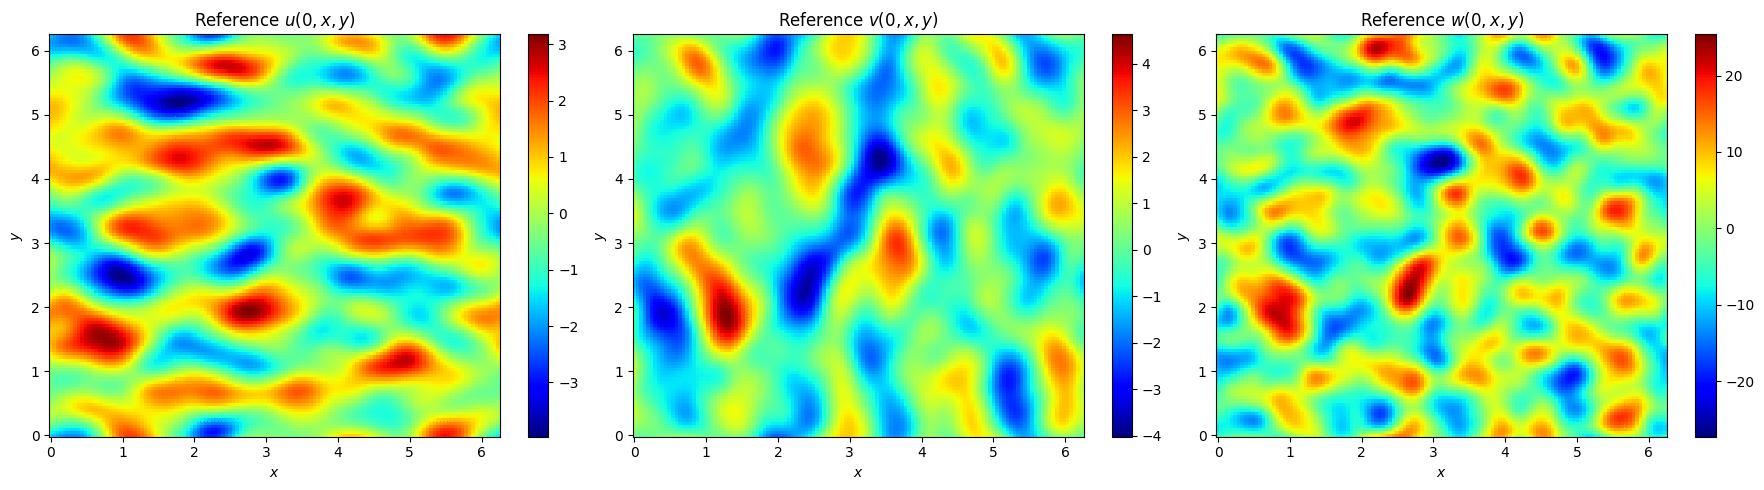

In [4]:
dtdt = 1
N_t = 100*dtdt
N_x = 90
N_y = 90
key = jax.random.PRNGKey(2023)
key, skey = jax.random.split(key)
dummy_x = jax.random.uniform(skey, (N_x, 1))
dummy_y = jax.random.uniform(skey, (N_y, 1))
key, skey = jax.random.split(skey)
params_uv = net_uv.init(skey, dummy_x, dummy_y)
params_k = net_k.init(skey, dummy_x, dummy_y)

# Load the reference solution
data = np.load('NS.npy', allow_pickle=True).item()
sol = data['sol']
t_star = data['t']
x_star = data['x']
y_star = data['y']
u0 = data['u0']
v0 = data['v0']
w0 = data['w0']
nu = data['viscosity']
XX, YY = np.meshgrid(x_star, y_star)
XX = XX.T
YY = YY.T

# Plot the reference solution
fig = plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.pcolor(XX, YY, u0, cmap='jet')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title(r'Reference $u(0,x,y)$')
plt.tight_layout()

plt.subplot(1, 3, 2)
plt.pcolor(XX, YY, v0, cmap='jet')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title(r'Reference $v(0,x,y)$')
plt.tight_layout()

plt.subplot(1, 3, 3)
plt.pcolor(XX, YY, w0, cmap='jet')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title(r'Reference $w(0,x,y)$')
plt.tight_layout()

# Sample point
X_r   = jnp.linspace(0, 2*jnp.pi, N_x)
Y_r   = jnp.linspace(0, 2*jnp.pi, N_y)
X_r, Y_r = jnp.meshgrid(X_r, Y_r)
X_r = X_r.T.reshape(-1, 1)                                  # used to train u
Y_r = Y_r.T.reshape(-1, 1)                                  # used to train u
X_star= XX.reshape(-1, 1)                                   # used to predict
Y_star= YY.reshape(-1, 1)                                   # used to predict
u0    = u0.reshape(-1, 1)                                   # reference solution of u(0,x,y)
v0    = v0.reshape(-1, 1)                                   # reference solution of v(0,x,y)
w0    = w0.reshape(-1, 1)                                   # reference solution of w(0,x,y)

In [5]:
# Train u0
start_time = time.time()
print('Training u0')

#logger
loss_u_log = []
loss_v_log = []
loss_w_log = []
l2_u_log = []
l2_v_log = []
l2_w_log = []

# optimizer & schedule
lr = 1e-2
schedule = optax.exponential_decay(
    init_value=lr,
    transition_steps=100,
    decay_rate=0.9
)
optimizer = optax.adam(learning_rate=schedule)

# Train state
state_uv = train_state.TrainState.create(apply_fn=net_uv.apply, params=params_uv, tx=optimizer)
state_k = train_state.TrainState.create(apply_fn=net_k.apply, params=params_k, tx=optimizer)

# Load state
# pkl_file = pickle.load(open('states/state{:d}.pkl'.format(0), 'rb'))
# state = flax.serialization.from_state_dict(state, pkl_file)

pbar = trange(1, 10000 + 1, ncols=200)
loss_min = 1e8
for nIter in pbar:
    state_uv, loss_u, loss_v, loss_w, loss_c = train_step_u0(state_uv, X_star, Y_star, u0, v0, w0)
    loss = loss_u + loss_v + loss_w + loss_c

    # Save the best state
    if loss < loss_min:
        state_dict = flax.serialization.to_state_dict(state_uv)
        pickle.dump(state_dict, open('states/state_uv{:d}.pkl'.format(0), 'wb'))
        loss_min = loss

    if nIter % 100 == 0:
        l2_w = jnp.linalg.norm(u0 - u_net(state_uv, state_uv.params, X_star, Y_star)) / jnp.linalg.norm(u0)
        l2_v = jnp.linalg.norm(v0 - v_net(state_uv, state_uv.params, X_star, Y_star)) / jnp.linalg.norm(v0)
        l2_w = jnp.linalg.norm(w0 - w_net(state_uv, state_uv.params, X_star, Y_star)) / jnp.linalg.norm(w0)

        loss_u_log.append(loss_u)
        loss_v_log.append(loss_v)
        loss_w_log.append(loss_w)
        l2_u_log.append(l2_w)
        l2_v_log.append(l2_v)
        l2_w_log.append(l2_w)
        pbar.set_postfix_str('loss:{:.2e}, min:{:.2e}, u:{:.2e}, v:{:.2e}, w:{:.2e}, c:{:.2e}, l2_u:{:.2e}, l2_v:{:.2e}, l2_w:{:.2e}'
                             .format(loss, loss_min, loss_u, loss_v, loss_w, loss_c, l2_w, l2_v, l2_w))

elapsed_u0 = time.time() - start_time

Training u0


100%|███████████████████████████████████| 10000/10000 [03:38<00:00, 45.68it/s, loss:5.68e-05, min:5.67e-05, u:2.77e-08, v:2.68e-08, w:2.95e-05, c:2.73e-05, l2_u:6.70e-04, l2_v:1.26e-04, l2_w:6.70e-04]


In [6]:
# Load the best state
# optimizer & schedule
lr = 1e-3
schedule = optax.exponential_decay(
    init_value=lr,
    transition_steps=1000,
    decay_rate=0.9
)
optimizer = optax.adam(learning_rate=schedule)
state_uv = train_state.TrainState.create(apply_fn=net_uv.apply, params=params_uv, tx=optimizer)
pkl_file = pickle.load(open('states/state_uv{:d}.pkl'.format(0), 'rb'))
state_uv = flax.serialization.from_state_dict(state_uv, pkl_file)

# Log u0
u_pred = []
v_pred = []
w_pred = []
l2_each_tn_log = []

u_pred.append(u_net(state_uv, state_uv.params, X_star, Y_star).reshape(len(x_star), len(y_star)))
v_pred.append(v_net(state_uv, state_uv.params, X_star, Y_star).reshape(len(x_star), len(y_star)))
w_pred.append(w_net(state_uv, state_uv.params, X_star, Y_star).reshape(len(x_star), len(y_star)))
sol_w = sol[0:1,:,:].reshape(len(w_pred[0]),-1)
l2_each_tn_log.append(jnp.linalg.norm(sol_w - w_pred[-1]) / jnp.linalg.norm(sol_w))

In [7]:
def pred_plot(true, pred, text):
    true = true.reshape(len(x_star), len(y_star))
    pred = pred.reshape(len(x_star), len(y_star))

    fig = plt.figure(figsize=(18, 5))
    plt.subplot(1, 3, 1)
    plt.pcolor(XX, YY, true, cmap='jet')
    plt.colorbar()
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.title(f'Reference {text}')
    plt.tight_layout()

    plt.subplot(1, 3, 2)
    plt.pcolor(XX, YY, pred, cmap='jet')
    plt.colorbar()
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.title(f'Predicted {text}')
    plt.tight_layout()

    plt.subplot(1, 3, 3)
    plt.pcolor(XX, YY, abs(true - pred), cmap='jet')
    plt.colorbar()
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.title('Absolute error')
    plt.tight_layout()
    plt.show()

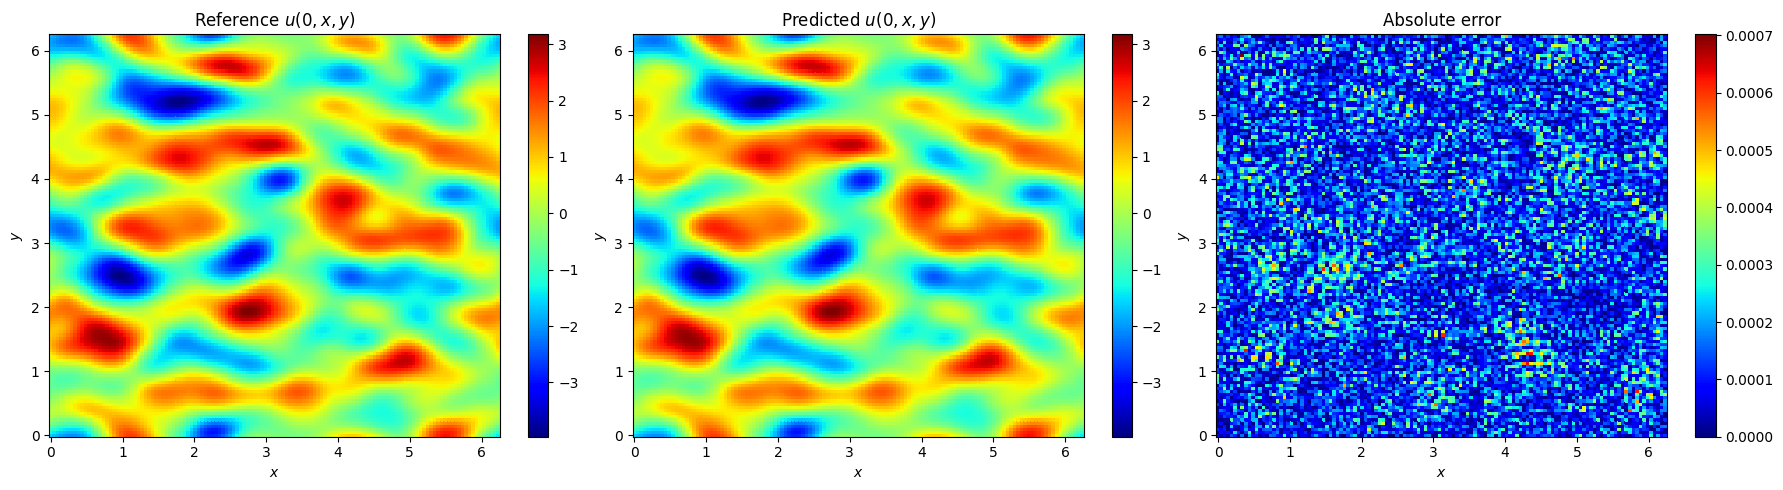

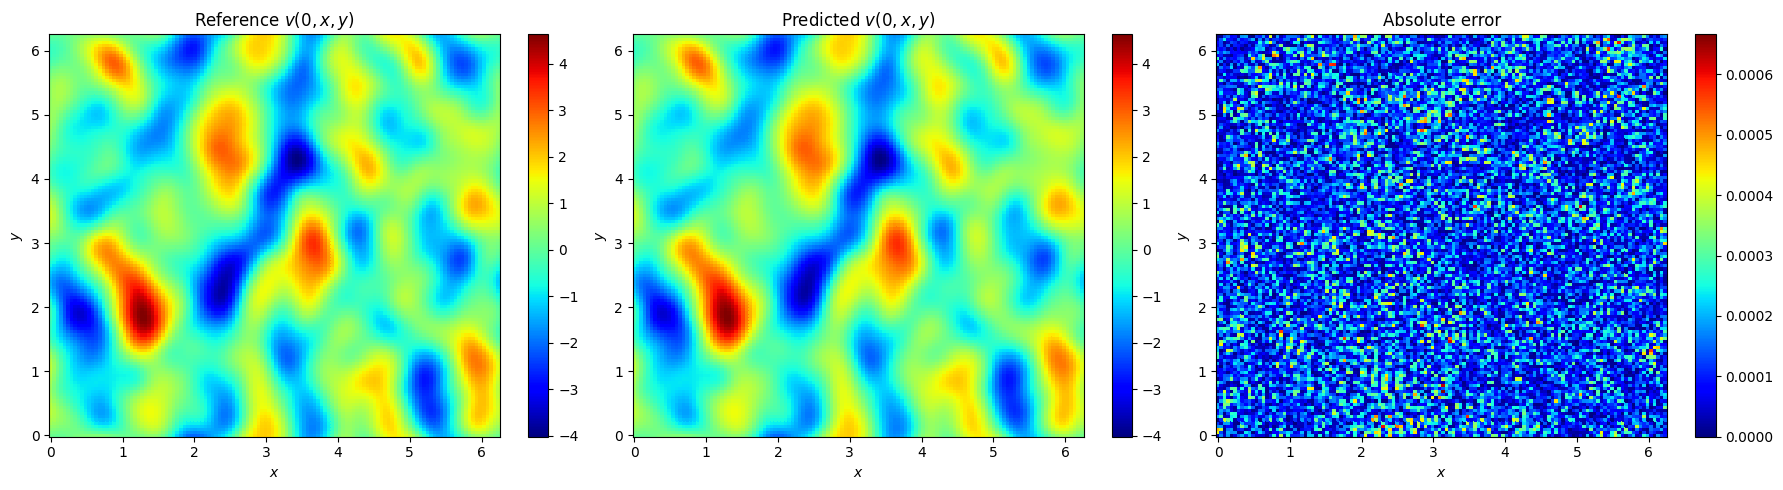

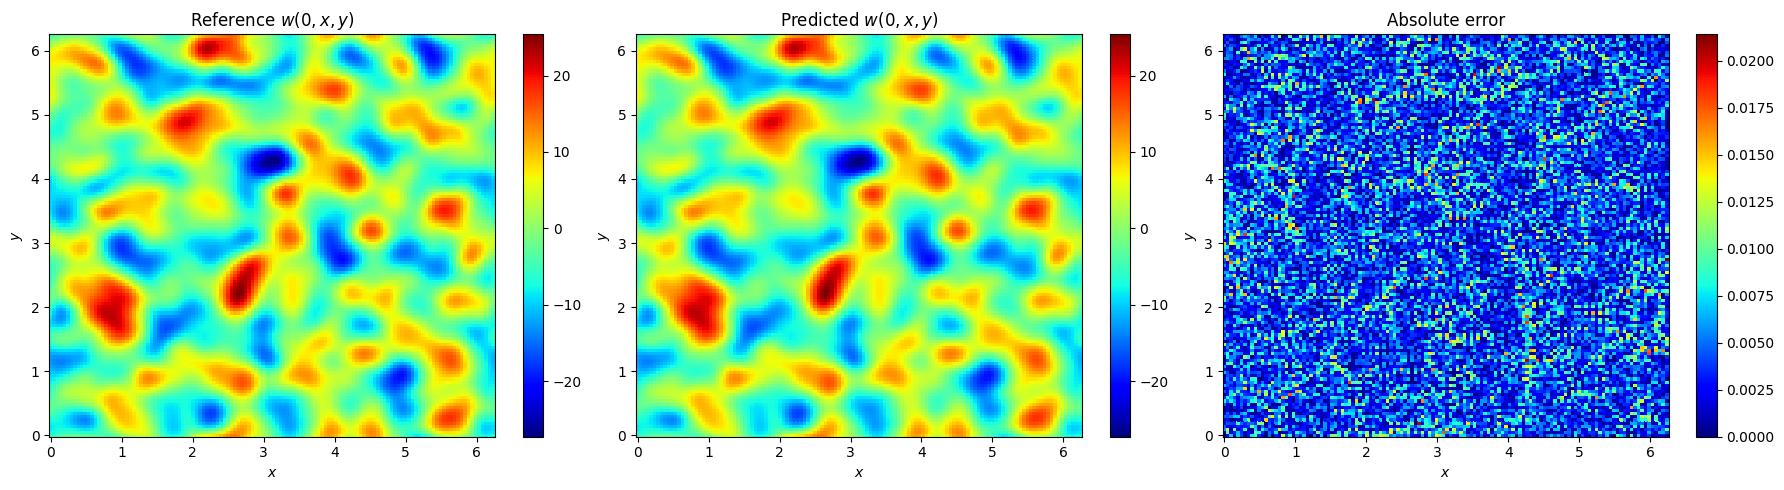

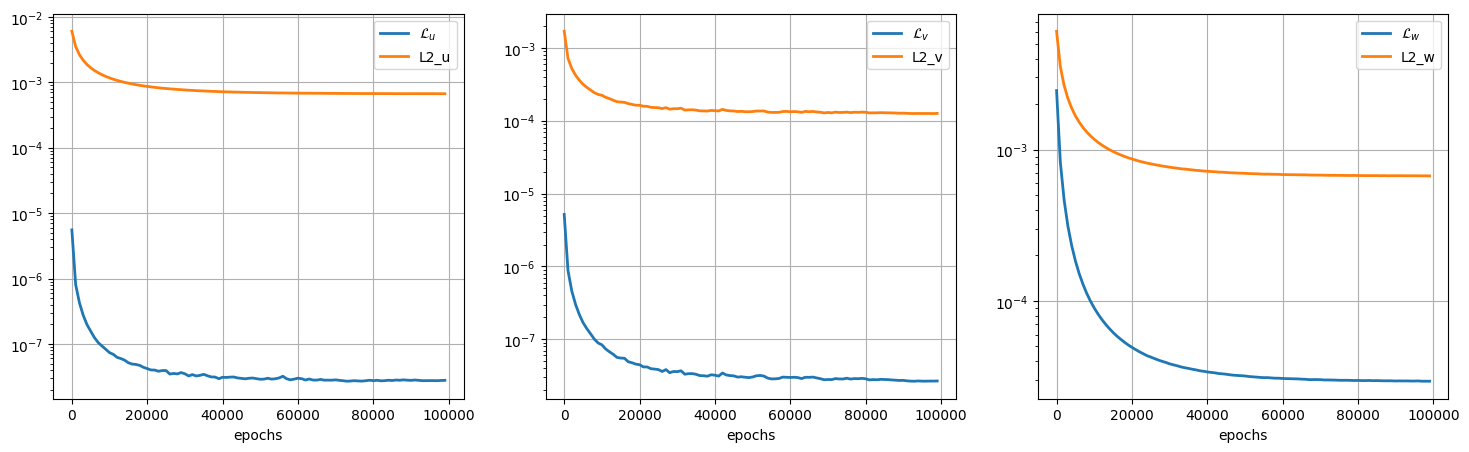

u0 training time: 219 s
L2 error: 6.70e-04


In [8]:
pred_plot(u0, u_pred[0], '$u(0,x,y)$')
pred_plot(v0, v_pred[0], '$v(0,x,y)$')
pred_plot(w0, w_pred[0], '$w(0,x,y)$')

fig = plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.yscale('log')
plt.plot(1000*np.arange(len(loss_u_log)), loss_u_log, label='$\mathcal{L}_{u}$', linewidth=2)
plt.plot(1000*np.arange(len(l2_u_log)), l2_u_log, label='L2_u', linewidth=2)
plt.xlabel('epochs')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.yscale('log')
plt.plot(1000*np.arange(len(loss_v_log)), loss_v_log, label='$\mathcal{L}_{v}$', linewidth=2)
plt.plot(1000*np.arange(len(l2_v_log)), l2_v_log, label='L2_v', linewidth=2)
plt.xlabel('epochs')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.yscale('log')
plt.plot(1000*np.arange(len(loss_w_log)), loss_w_log, label='$\mathcal{L}_{w}$', linewidth=2)
plt.plot(1000*np.arange(len(l2_w_log)), l2_w_log, label='L2_w', linewidth=2)
plt.xlabel('epochs')
plt.legend()
plt.grid(True)
plt.show()

print('u0 training time: {:.0f} s'.format(elapsed_u0))
print('L2 error: {:.2e}'.format(l2_each_tn_log[0]))

In [ ]:
# Train u1 u2 u3 ...
start_time_rest = time.time()
print('Training u1 u2 u3 ...')

# optimizer & schedule
lr = 1e-3
schedule = optax.exponential_decay(
    init_value=lr,
    transition_steps=50,
    decay_rate=0.9
)
optimizer = optax.adam(learning_rate=schedule)

# logger
steps_each_tn_log = []
loss_min_log = []
res_w_log = []
res_c_log = []

state_uv = train_state.TrainState.create(apply_fn=net_uv.apply, params=state_uv.params, tx=optimizer)
state_k = train_state.TrainState.create(apply_fn=net_k.apply, params=params_k, tx=optimizer)

pbar = trange(1, N_t + 1, ncols=160)
for t_n in pbar:

    loss_last = 0
    loss_min = 1e8
    loss_patience = 0
    res_w_each_tn_log = []
    res_c_each_tn_log = []
    
    uk_fn = lambda x, y: u_net(state_uv, state_uv.params, x, y)
    uk_x_fn = diff(uk_fn, 0)
    uk = uk_fn(X_r, Y_r)
    uk_x = uk_x_fn(X_r, Y_r)

    vk_fn = lambda x, y: v_net(state_uv, state_uv.params, x, y)
    vk_y_fn = diff(vk_fn, 1)
    vk = vk_fn(X_r, Y_r)
    vk_y = vk_y_fn(X_r, Y_r)

    wk_fn = lambda x, y: w_net(state_uv, state_uv.params, x, y)
    wk_x_fn = diff(wk_fn, 0)
    wk_xx_fn = diff(wk_x_fn, 0)
    wk_y_fn = diff(wk_fn, 1)
    wk_yy_fn = diff(wk_y_fn, 1)
    wk = wk_fn(X_r, Y_r)
    wk_x = wk_x_fn(X_r, Y_r)
    wk_xx = wk_xx_fn(X_r, Y_r)
    wk_y = wk_y_fn(X_r, Y_r)
    wk_yy = wk_yy_fn(X_r, Y_r)

    state_uv = train_state.TrainState.create(apply_fn=net_uv.apply, params=state_uv.params, tx=optimizer)
    state_k = train_state.TrainState.create(apply_fn=net_k.apply, params=state_k.params, tx=optimizer)

    for steps in range(1, 5000 + 1):
        state_uv, state_k, loss_k1, loss_k2, loss, loss_w, loss_c = train_step_rest(state_uv, state_k, X_r, Y_r, wk, wk_x, wk_xx, wk_y, wk_yy, uk, uk_x, vk, vk_y, N_t, nu)
        # loss = loss_w + loss_c
        pbar.set_postfix_str('steps:{:4d}, loss:{:.2e}, min:{:.2e}, w:{:.2e}, c:{:.2e}, k1:{:.2e}, k2:{:.2e}, l2_last:{:.2e}'
                             .format(steps, loss, loss_min, loss_w, loss_c, loss_k1, loss_k2, l2_each_tn_log[-1]))
        res_w_each_tn_log.append(loss_w)
        res_c_each_tn_log.append(loss_c)
        
        # Save the best state
        if loss < loss_min:
            state_dict_uv = flax.serialization.to_state_dict(state_uv)
            state_dict_k = flax.serialization.to_state_dict(state_k)
            pickle.dump(state_dict_uv, open('states/state_uv{:d}.pkl'.format(t_n), 'wb'))
            pickle.dump(state_dict_k, open('states/state_k{:d}.pkl'.format(t_n), 'wb'))
            loss_min = loss 
            loss_patience = steps
        
        if steps>300 and (0<loss_last-loss<=1e-6 or steps-loss_patience>100):
            break
        loss_last = loss

    # Load the best state
    pkl_file_uv = pickle.load(open('states/state_uv{:d}.pkl'.format(t_n), 'rb'))
    pkl_file_k = pickle.load(open('states/state_k{:d}.pkl'.format(t_n), 'rb'))
    state_uv = flax.serialization.from_state_dict(state_uv, pkl_file_uv)
    state_k = flax.serialization.from_state_dict(state_k, pkl_file_k)
    if t_n % (N_t/100) == 0:
        w_pred.append(w_net(state_uv, state_uv.params, X_star, Y_star).reshape(len(x_star), len(y_star)))
        sol_index = int(t_n/N_t*100)
        sol_w = sol[sol_index:sol_index+1,:,:].reshape(len(w_pred[0]),-1)
        l2_each_tn_log.append(jnp.linalg.norm(sol_w - w_pred[-1]) / jnp.linalg.norm(sol_w))
    
    # Log
    steps_each_tn_log.append(steps)
    loss_min_log.append(loss_min)
    res_w_log.append(res_w_each_tn_log)
    res_c_log.append(res_c_each_tn_log)

elapsed_rest = time.time() - start_time_rest

In [ ]:
path = 'result_rk'
pickle.dump(w_pred, open(f'{path}/w_pred.pkl', 'wb'))
pickle.dump(res_w_log, open(f'{path}/res_w.pkl', 'wb'))
pickle.dump(res_c_log, open(f'{path}/res_c.pkl', 'wb'))
pickle.dump(loss_min_log, open(f'{path}/loss_min.pkl', 'wb'))
pickle.dump(l2_each_tn_log, open(f'{path}/l2_each_tn.pkl', 'wb'))
pickle.dump(steps_each_tn_log, open(f'{path}/steps_each_tn.pkl', 'wb'))

In [3]:
# path = 'result_rk'
# w_pred = pickle.load(open(f'{path}/w_pred.pkl', 'rb'))
# res_w_log = pickle.load(open(f'{path}/res_w.pkl', 'rb'))
# res_c_log = pickle.load(open(f'{path}/res_c.pkl', 'rb'))
# loss_min_log = pickle.load(open(f'{path}/loss_min.pkl', 'rb'))
# l2_each_tn_log = pickle.load(open(f'{path}/l2_each_tn.pkl', 'rb'))
# steps_each_tn_log = pickle.load(open(f'{path}/steps_each_tn.pkl', 'rb'))

In [ ]:
schedule = optax.exponential_decay(init_value=1e-3, transition_steps=1000, decay_rate=0.9)
optimizer = optax.adam(learning_rate=schedule)
state_uv = train_state.TrainState.create(apply_fn=net_uv.apply, params=params_uv, tx=optimizer)
l2_each_tn_log = []
w_pred = []
for t_n in range(0, N_t+1):
    if t_n % dtdt == 0:
        pkl_file = pickle.load(open('states/state{:d}.pkl'.format(t_n), 'rb'))
        state_uv = flax.serialization.from_state_dict(state_uv, pkl_file)

        w_pred.append(w_net(state_uv, state_uv.params, X_star, Y_star).reshape(len(x_star), len(y_star)))
        sol_index = int(t_n/dtdt)
        sol_w = sol[sol_index:sol_index+1,:,:]
        l2_each_tn_log.append(jnp.linalg.norm(sol_w - w_pred[-1]) / jnp.linalg.norm(sol_w))
print(len(l2_each_tn_log))
print(len(w_pred))

101
101


In [ ]:
w_pred_copy = w_pred

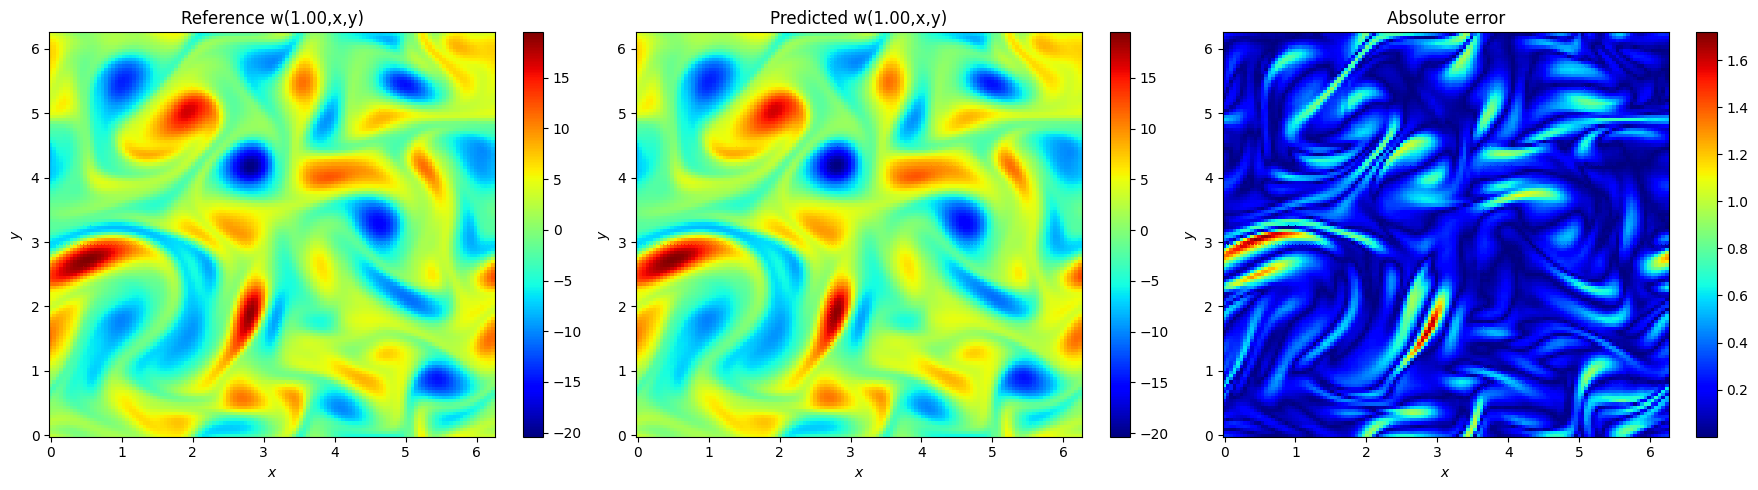

training time after u0: 19443 s
total time: 19660 s
L2 error = 3.79600e-02


In [ ]:
# reshape to the same format & compute L2 error
w_pred = w_pred_copy
sol_1 = sol[100:101,:,:]
l2_w = np.linalg.norm(sol[:101,:,:] - w_pred) / np.linalg.norm(sol[:101,:,:])

pred_plot(sol_1, w_pred[-1], 'w({:.2f},x,y)'.format((len(w_pred)-1)/N_t))

print('training time after u0: {:.0f} s'.format(elapsed_rest))
print('total time: {:.0f} s'.format(elapsed_u0+elapsed_rest))
print('L2 error = {:.5e}'.format(l2_w))

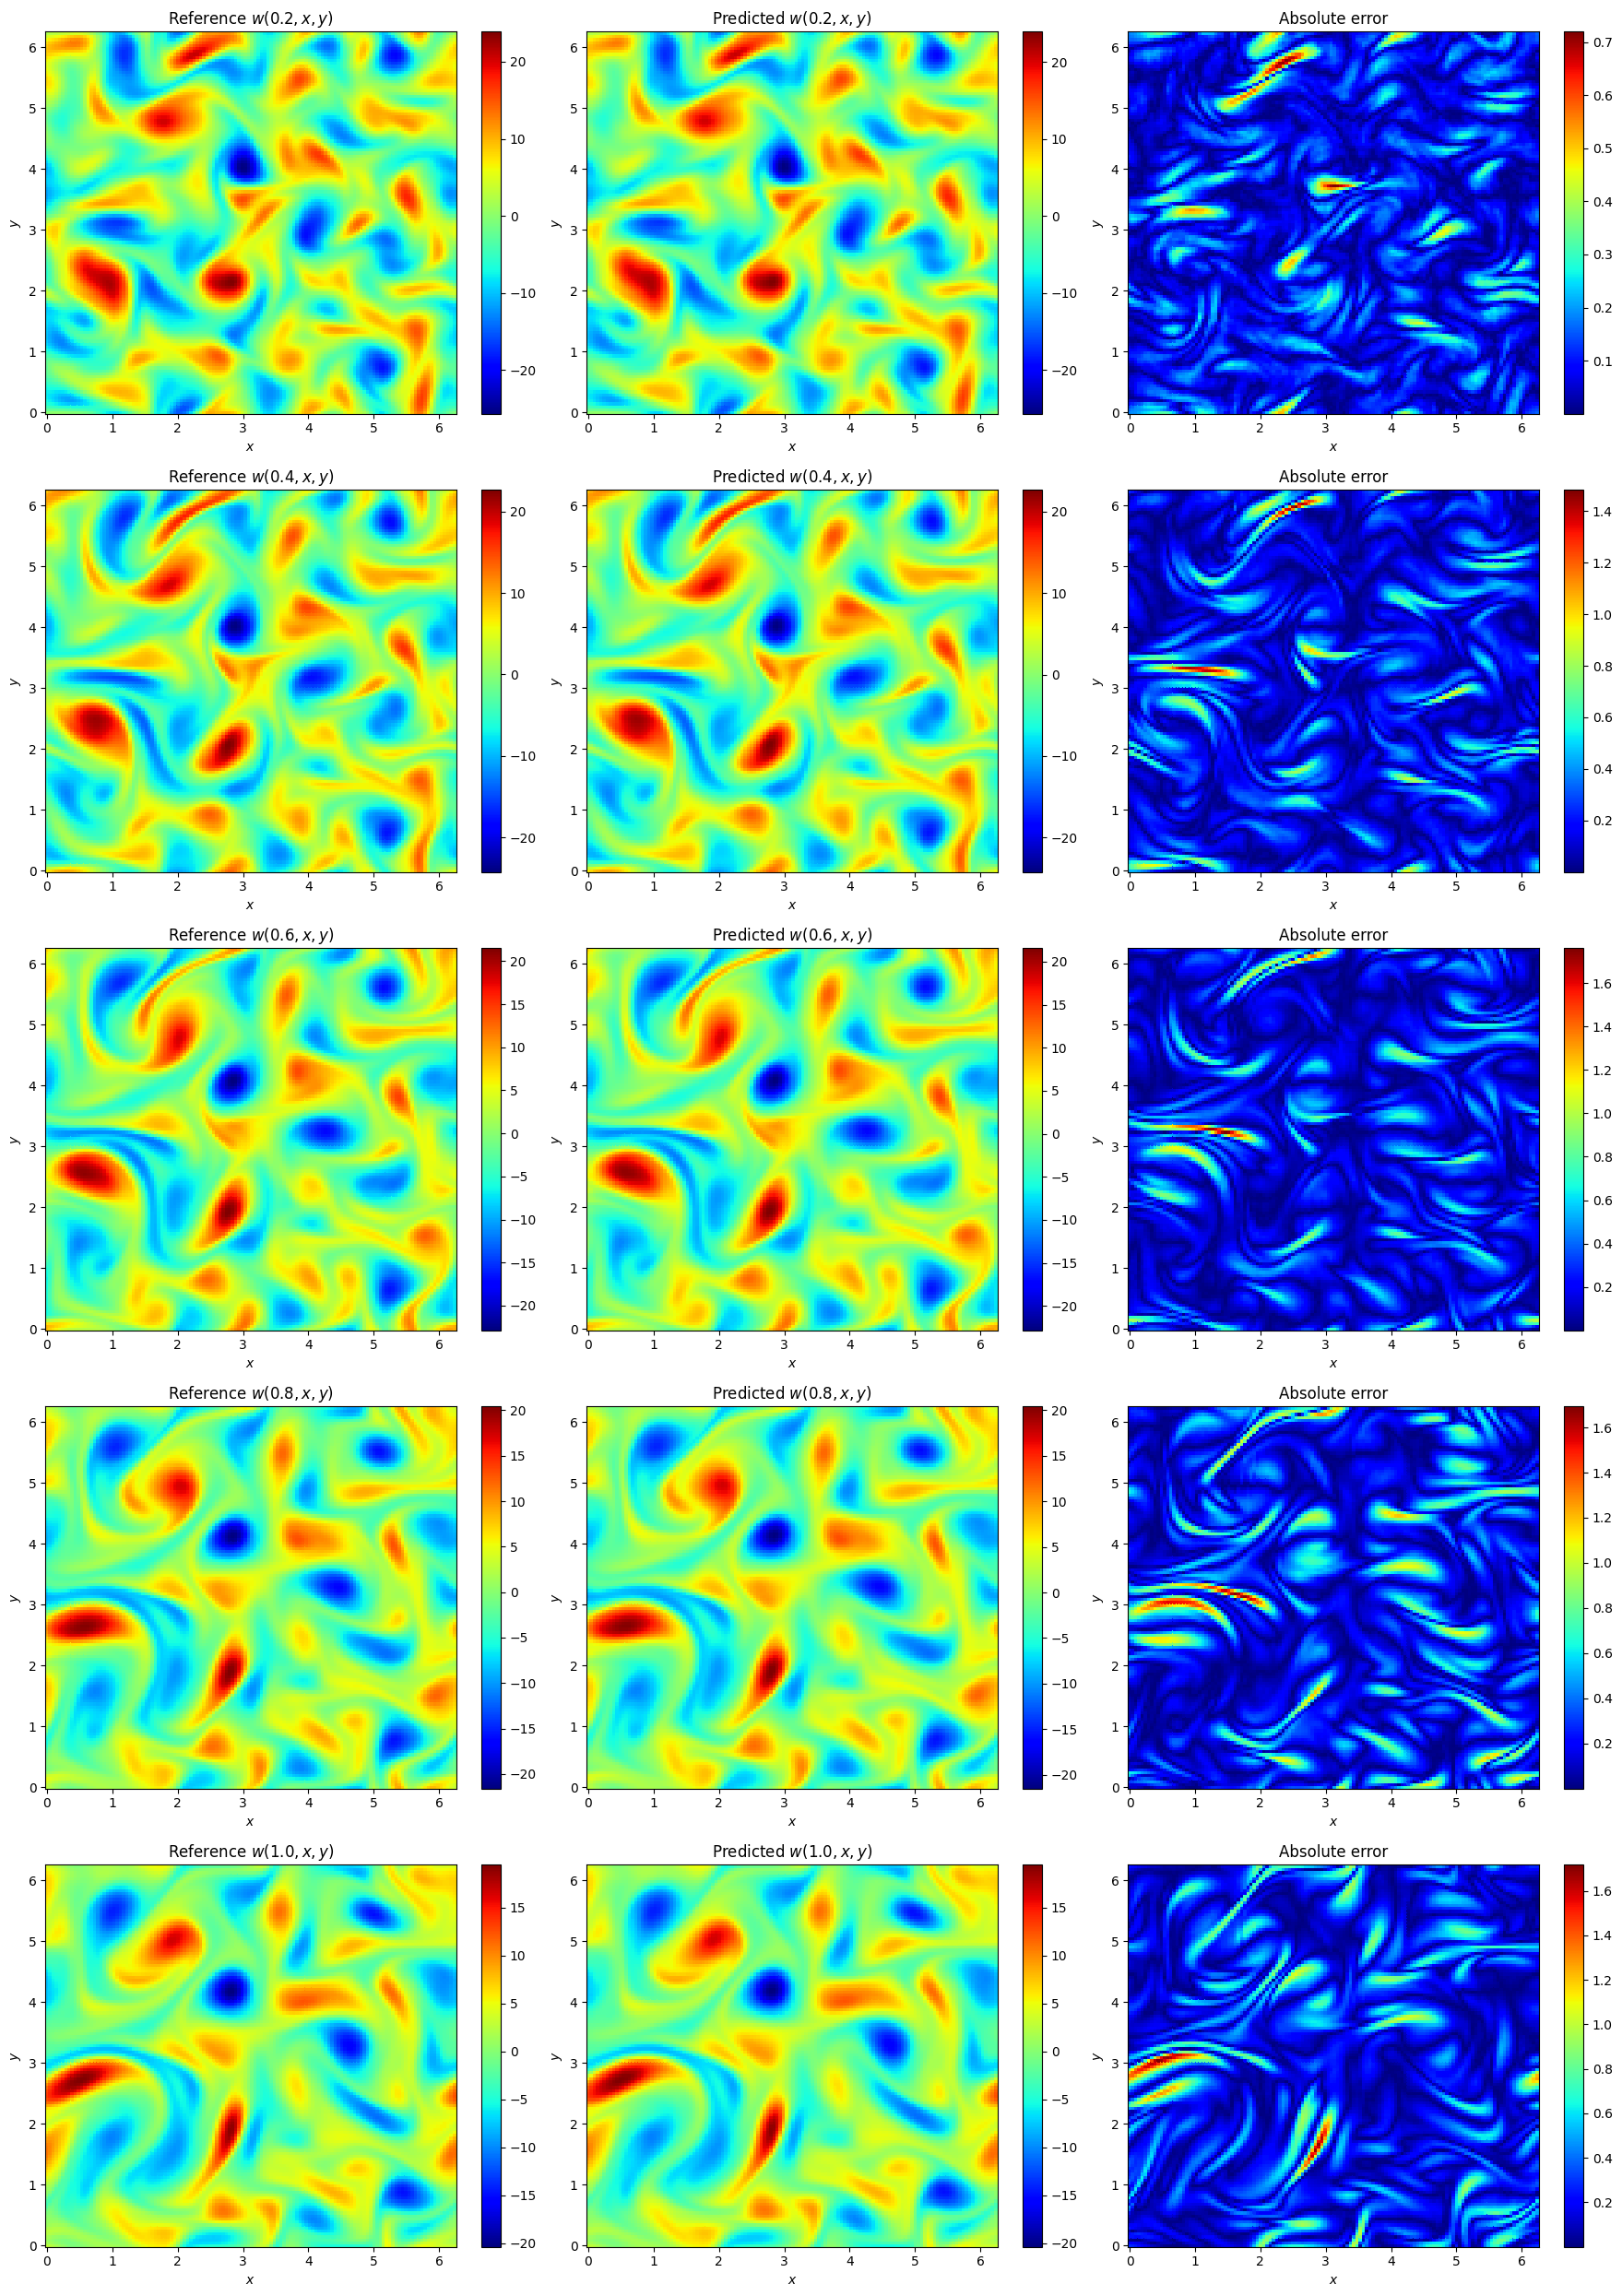

In [ ]:
# plot t = 0.2, 0.4, 0.6, 0.8, 1.0
fig = plt.figure(figsize=(18, 25))
for t in range(1, 6):
    plt.subplot(5, 3, 3*t-2)
    plt.pcolor(XX, YY, sol[20*t], cmap='jet')
    plt.colorbar()
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.title('Reference $w({:.1f},x,y)$'.format(t*0.2))
    plt.tight_layout()

    plt.subplot(5, 3, 3*t-1)
    plt.pcolor(XX, YY, w_pred[20*t], cmap='jet')
    plt.colorbar()
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.title('Predicted $w({:.1f},x,y)$'.format(t*0.2))
    plt.tight_layout()

    plt.subplot(5, 3, 3*t)
    plt.pcolor(XX, YY, abs(sol[20*t] - w_pred[20*t]), cmap='jet')
    plt.colorbar()
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.title('Absolute error')
    plt.tight_layout()

plt.show()

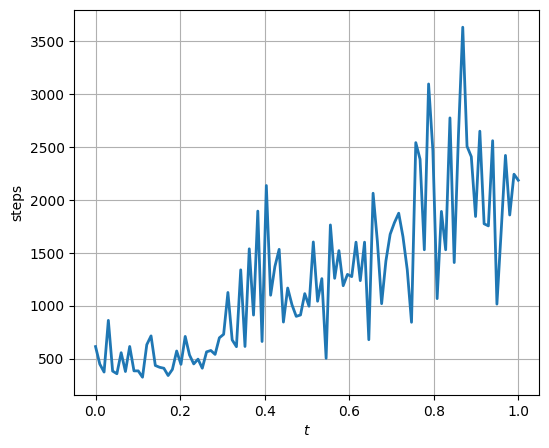

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.plot(np.linspace(0, 1, len(steps_each_tn_log)), steps_each_tn_log, linewidth=2)
ax.set_xlabel('$t$')
ax.set_ylabel('steps')
# ax.set_title('steps each t_n')
ax.grid(True)
plt.show()

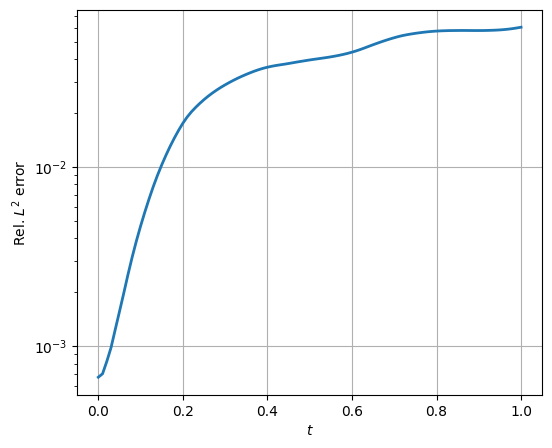

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
plt.yscale('log')
ax.plot(np.linspace(0, 1, len(l2_each_tn_log)), l2_each_tn_log, linewidth=2)
ax.set_xlabel('$t$')
ax.set_ylabel('Rel. $L^2$ error')
# ax.set_title('L2 error each t_n')
ax.grid(True)
plt.show()

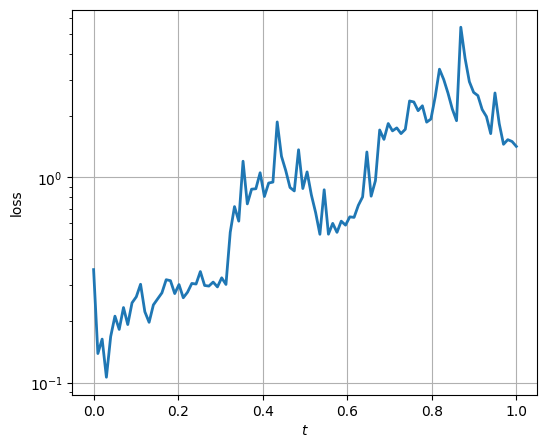

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
plt.yscale('log')
ax.plot(np.linspace(0, 1, len(loss_min_log)), loss_min_log, linewidth=2)
ax.set_xlabel('$t$')
ax.set_ylabel('loss')
# ax.set_title('loss min each tn')
ax.grid(True)
plt.show()

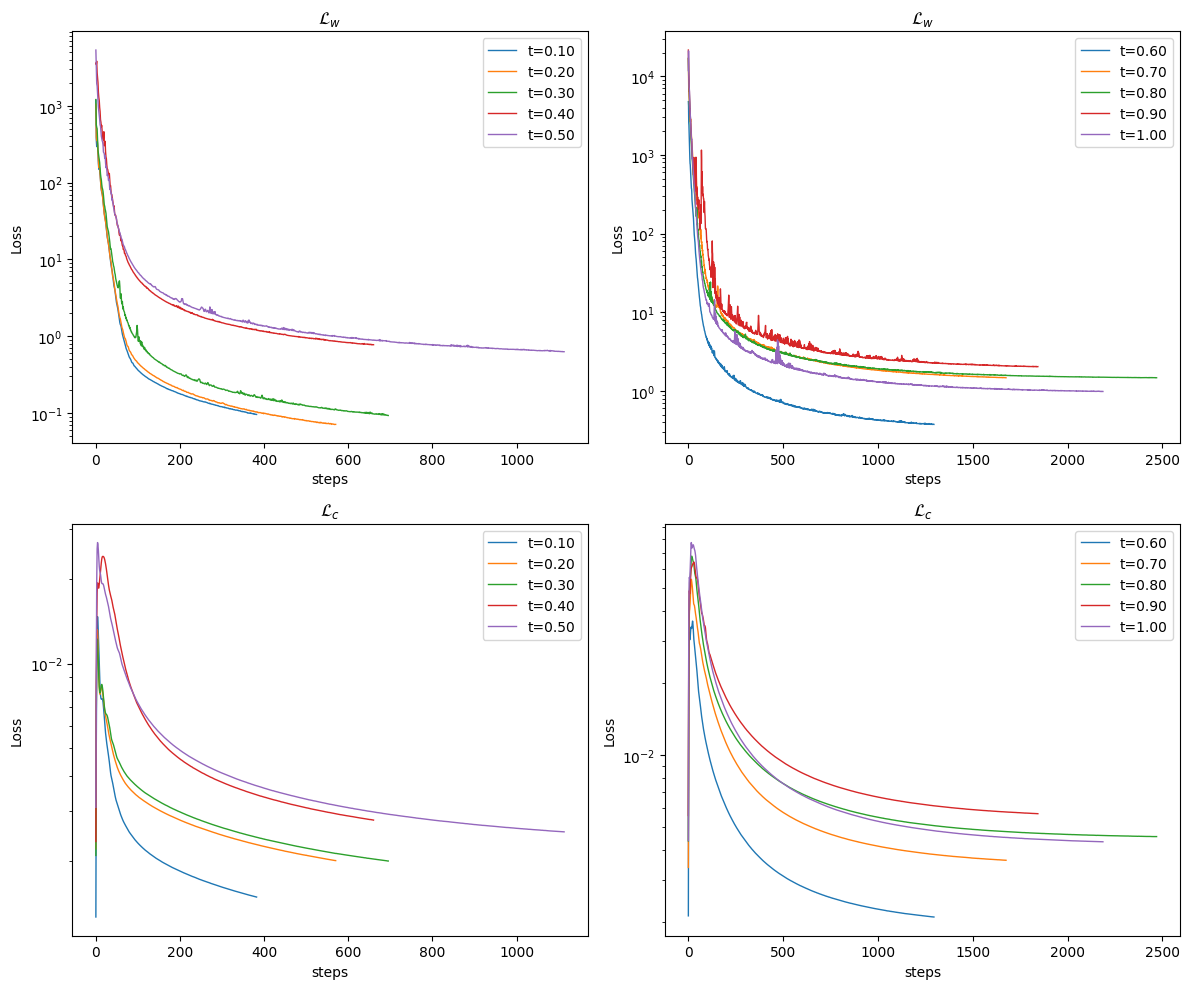

In [ ]:
# res_w values of several time stamps
fig = plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
plt.yscale('log')
plt.plot(np.arange(len(res_w_log[9])), res_w_log[9], label='t=0.10', linewidth=1)
plt.plot(np.arange(len(res_w_log[19])), res_w_log[19], label='t=0.20', linewidth=1)
plt.plot(np.arange(len(res_w_log[29])), res_w_log[29], label='t=0.30', linewidth=1)
plt.plot(np.arange(len(res_w_log[39])), res_w_log[39], label='t=0.40', linewidth=1)
plt.plot(np.arange(len(res_w_log[49])), res_w_log[49], label='t=0.50', linewidth=1)
plt.xlabel('steps')
plt.ylabel('Loss')
plt.title('$\mathcal{L}_{w}$')
plt.legend()
plt.tight_layout()

plt.subplot(2, 2, 2)
plt.yscale('log')
plt.plot(np.arange(len(res_w_log[59])), res_w_log[59], label='t=0.60', linewidth=1)
plt.plot(np.arange(len(res_w_log[69])), res_w_log[69], label='t=0.70', linewidth=1)
plt.plot(np.arange(len(res_w_log[79])), res_w_log[79], label='t=0.80', linewidth=1)
plt.plot(np.arange(len(res_w_log[89])), res_w_log[89], label='t=0.90', linewidth=1)
plt.plot(np.arange(len(res_w_log[99])), res_w_log[99], label='t=1.00', linewidth=1)
plt.xlabel('steps')
plt.ylabel('Loss')
plt.title('$\mathcal{L}_{w}$')
plt.legend()
plt.tight_layout()

plt.subplot(2, 2, 3)
plt.yscale('log')
plt.plot(np.arange(len(res_c_log[9])), res_c_log[9], label='t=0.10', linewidth=1)
plt.plot(np.arange(len(res_c_log[19])), res_c_log[19], label='t=0.20', linewidth=1)
plt.plot(np.arange(len(res_c_log[29])), res_c_log[29], label='t=0.30', linewidth=1)
plt.plot(np.arange(len(res_c_log[39])), res_c_log[39], label='t=0.40', linewidth=1)
plt.plot(np.arange(len(res_c_log[49])), res_c_log[49], label='t=0.50', linewidth=1)
plt.xlabel('steps')
plt.ylabel('Loss')
plt.title('$\mathcal{L}_{c}$')
plt.legend()
plt.tight_layout()

plt.subplot(2, 2, 4)
plt.yscale('log')
plt.plot(np.arange(len(res_c_log[59])), res_c_log[59], label='t=0.60', linewidth=1)
plt.plot(np.arange(len(res_c_log[69])), res_c_log[69], label='t=0.70', linewidth=1)
plt.plot(np.arange(len(res_c_log[79])), res_c_log[79], label='t=0.80', linewidth=1)
plt.plot(np.arange(len(res_c_log[89])), res_c_log[89], label='t=0.90', linewidth=1)
plt.plot(np.arange(len(res_c_log[99])), res_c_log[99], label='t=1.00', linewidth=1)
plt.xlabel('steps')
plt.ylabel('Loss')
plt.title('$\mathcal{L}_{c}$')
plt.legend()
plt.tight_layout()

plt.show()

In [ ]:
# plot for video
for t in range(101):
    plt.figure(figsize=(18, 5))
    plt.subplot(1, 3, 1)
    plt.pcolor(XX, YY, sol[t], cmap='jet', vmin=-20, vmax=20)
    plt.colorbar()
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.title('Reference $w({:.2f},x,y)$'.format(t/100))
    plt.tight_layout()

    plt.subplot(1, 3, 2)
    plt.pcolor(XX, YY, w_pred[t], cmap='jet', vmin=-20, vmax=20)
    plt.colorbar()
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.title('Predicted $w({:.2f},x,y)$'.format(t/100))
    plt.tight_layout()

    plt.subplot(1, 3, 3)
    plt.pcolor(XX, YY, abs(sol[t] - w_pred[t]), cmap='jet', vmin=0, vmax=2.5)
    plt.colorbar(extend='max')
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.title('Absolute error')
    plt.tight_layout()

    plt.savefig('./video_plot/image_{:d}'.format(t))

In [23]:
# make video
import cv2
import os

image_folder = './video_plot/'
video_name = 'NS_CN.mp4'

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
video = cv2.VideoWriter(video_name, fourcc, 10, (width,height))

for t in range(101):
    image = cv2.imread('./video_plot/image_{:d}.png'.format(t))
    video.write(image)

video.release()
cv2.destroyAllWindows()

# Convert to H264 codec
os.system(f'ffmpeg -i {video_name} -vcodec h264 H264_{video_name} -y')

ModuleNotFoundError: No module named 'cv2'